<a href="https://colab.research.google.com/github/BirasaDivine/Malaria-Cell-Classification/blob/main/VGG16_FirstColab_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.regularizers import l2
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc as sk_auc
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import time
import math
import os
import shutil
import zipfile
import random
from datetime import datetime
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_curve,
    auc,
    precision_recall_curve,
    f1_score
)

In [ ]:
from tensorflow.keras.callbacks import TensorBoard
import datetime as dt

print("="*80)
print("MALARIA DIAGNOSIS: BASELINE & ADVANCED CNN")
print("="*80)
print(f"TensorFlow Version: {tf.__version__}")  # Changed from tf._version_
print(f"GPU Devices: {tf.config.list_physical_devices('GPU')}")
if tf.config.list_physical_devices('GPU'):
    print("✅ GPU is available and will be used for training!")
else:
    print("⚠️ No GPU detected. Training will use CPU (slower).")
print("="*80)

MALARIA DIAGNOSIS: BASELINE & ADVANCED CNN
TensorFlow Version: 2.19.0
GPU Devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
✅ GPU is available and will be used for training!


In [ ]:
print("\n" + "="*80)
print("DOWNLOADING MALARIA CELL IMAGES DATASET")
print("="*80)

# Download dataset
print("Downloading dataset from NIH...")
!wget -q https://data.lhncbc.nlm.nih.gov/public/Malaria/cell_images.zip
print("✅ Dataset downloaded!")

# Extract
print("\nExtracting dataset...")
with zipfile.ZipFile('cell_images.zip', 'r') as zip_ref:
    zip_ref.extractall('.')
print("✅ Dataset extracted!")

# Verify dataset structure
print("\n📁 Dataset Structure:")
print(f"Contents: {os.listdir('cell_images')}")

# Count images
parasitized_count = len(os.listdir('cell_images/Parasitized'))
uninfected_count = len(os.listdir('cell_images/Uninfected'))
total_images = parasitized_count + uninfected_count

print(f"\n📊 Dataset Statistics:")
print(f"  Parasitized cells: {parasitized_count:,}")
print(f"  Uninfected cells: {uninfected_count:,}")
print(f"  Total images: {total_images:,}")
print(f"  Class balance: Parasitized {parasitized_count/total_images:.1%}, Uninfected {uninfected_count/total_images:.1%}")

if abs(parasitized_count - uninfected_count) / total_images < 0.1:
    print("  ✅ Dataset is well-balanced!")
else:
    print("  ⚠️ Dataset has class imbalance")

print("="*80)


DOWNLOADING MALARIA CELL IMAGES DATASET
✅ Dataset downloaded!

Extracting dataset...
✅ Dataset extracted!

📁 Dataset Structure:
Contents: ['Uninfected', 'Parasitized']

📊 Dataset Statistics:
  Parasitized cells: 13,780
  Uninfected cells: 13,780
  Total images: 27,560
  Class balance: Parasitized 50.0%, Uninfected 50.0%
  ✅ Dataset is well-balanced!



VISUALIZING SAMPLE CELL IMAGES


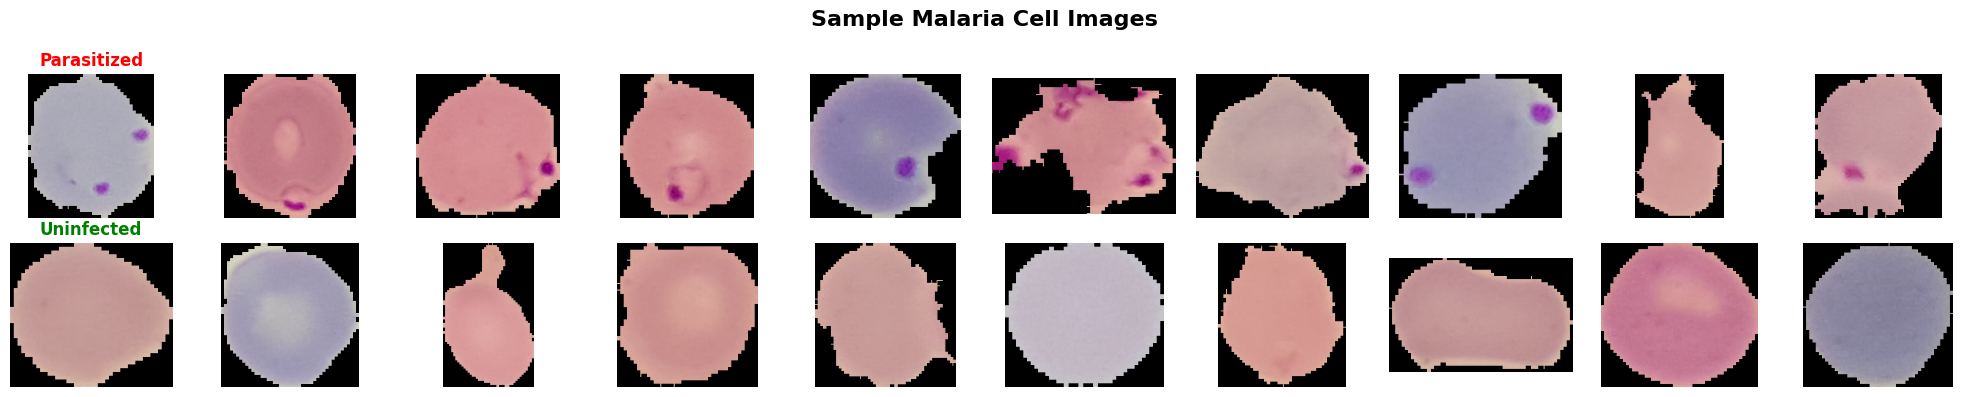

💡 Visual Differences:
  - Parasitized: Purple/pink staining indicates malaria parasites
  - Uninfected: Normal red blood cell appearance

✅ Saved: sample_images.png


In [ ]:
print("\n" + "="*80)
print("VISUALIZING SAMPLE CELL IMAGES")
print("="*80)

def visualize_samples(num_samples=10):
    """Visualize random samples from both classes"""

    fig, axes = plt.subplots(2, num_samples, figsize=(20, 4))

    # Parasitized samples
    parasitized_dir = 'cell_images/Parasitized'
    parasitized_images = os.listdir(parasitized_dir)[:num_samples]

    for i, img_name in enumerate(parasitized_images):
        img_path = os.path.join(parasitized_dir, img_name)
        img = imread(img_path)
        axes[0, i].imshow(img)
        axes[0, i].axis('off')
        if i == 0:
            axes[0, i].set_title('Parasitized', fontsize=12, fontweight='bold', color='red')

    # Uninfected samples
    uninfected_dir = 'cell_images/Uninfected'
    uninfected_images = os.listdir(uninfected_dir)[:num_samples]

    for i, img_name in enumerate(uninfected_images):
        img_path = os.path.join(uninfected_dir, img_name)
        img = imread(img_path)
        axes[1, i].imshow(img)
        axes[1, i].axis('off')
        if i == 0:
            axes[1, i].set_title('Uninfected', fontsize=12, fontweight='bold', color='green')

    plt.suptitle('Sample Malaria Cell Images', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig('sample_images.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("💡 Visual Differences:")
    print("  - Parasitized: Purple/pink staining indicates malaria parasites")
    print("  - Uninfected: Normal red blood cell appearance")
    print("\n✅ Saved: sample_images.png")

visualize_samples(10)

In [ ]:
# Define the useful paths for data accessibility
ai_project = '.' #"/content/drive/My Drive/Colab Notebooks/ai-labs/malaria-diagnosis"
cell_images_dir = os.path.join(ai_project,'cell_images')
training_path = os.path.join(ai_project,'train')
testing_path = os.path.join(ai_project,'test')

In [ ]:
# create train/validation/test split
import numpy as np
def create_train_test_split(source_dir, train_dir, test_dir,
                           train_ratio=0.8, val_ratio=0.1, seed=42):
    """
    Split data into train, validation, and test sets

    Args:
        source_dir: Directory containing 'Parasitized' and 'Uninfected' folders
        train_dir: Output directory for training data
        test_dir: Output directory for test data
        train_ratio: Proportion for training (0.8 = 80%)
        val_ratio: Proportion for validation (0.1 = 10%)
        seed: Random seed for reproducibility
    """

    # Set random seed
    random.seed(seed)
    np.random.seed(seed)

    # Remove existing train/test directories if they exist
    if os.path.exists(train_dir):
        shutil.rmtree(train_dir)
    if os.path.exists(test_dir):
        shutil.rmtree(test_dir)

    # Create directory structure
    for split_dir in [train_dir, test_dir]:
        os.makedirs(split_dir, exist_ok=True)
        os.makedirs(os.path.join(split_dir, 'Parasitized'), exist_ok=True)
        os.makedirs(os.path.join(split_dir, 'Uninfected'), exist_ok=True)

    # We'll use test_dir for validation during training
    # and create a separate validation directory
    val_dir = 'validation'
    if os.path.exists(val_dir):
        shutil.rmtree(val_dir)
    os.makedirs(val_dir, exist_ok=True)
    os.makedirs(os.path.join(val_dir, 'Parasitized'), exist_ok=True)
    os.makedirs(os.path.join(val_dir, 'Uninfected'), exist_ok=True)

    # Process each class
    classes = ['Parasitized', 'Uninfected']
    split_stats = {'train': {}, 'val': {}, 'test': {}}

    for class_name in classes:
        # Get all images for this class
        class_dir = os.path.join(source_dir, class_name)
        images = os.listdir(class_dir)
        random.shuffle(images)

        # Calculate split indices
        total = len(images)
        train_end = int(total * train_ratio)
        val_end = train_end + int(total * val_ratio)

        # Split images
        train_images = images[:train_end]
        val_images = images[train_end:val_end]
        test_images = images[val_end:]

        # Copy images to respective directories
        for img in train_images:
            shutil.copy2(
                os.path.join(class_dir, img),
                os.path.join(train_dir, class_name, img)
            )

        for img in val_images:
            shutil.copy2(
                os.path.join(class_dir, img),
                os.path.join(val_dir, class_name, img)
            )

        for img in test_images:
            shutil.copy2(
                os.path.join(class_dir, img),
                os.path.join(test_dir, class_name, img)
            )

        # Store statistics
        split_stats['train'][class_name] = len(train_images)
        split_stats['val'][class_name] = len(val_images)
        split_stats['test'][class_name] = len(test_images)

    return val_dir, split_stats

# Create splits
print(" Creating train/validation/test splits...")
print("  Train: 80%, Validation: 10%, Test: 10%")

val_dir, split_stats = create_train_test_split(
    cell_images_dir,
    training_path,
    testing_path,
    train_ratio=0.8,
    val_ratio=0.1,
    seed=42
)

# Print statistics
print("\n Data split completed!")
print("\n Split Statistics:")
print(f"\nTraining Set:")
print(f"  Parasitized: {split_stats['train']['Parasitized']:,}")
print(f"  Uninfected: {split_stats['train']['Uninfected']:,}")
print(f"  Total: {sum(split_stats['train'].values()):,}")

print(f"\nValidation Set:")
print(f"  Parasitized: {split_stats['val']['Parasitized']:,}")
print(f"  Uninfected: {split_stats['val']['Uninfected']:,}")
print(f"  Total: {sum(split_stats['val'].values()):,}")

print(f"\nTest Set:")
print(f"  Parasitized: {split_stats['test']['Parasitized']:,}")
print(f"  Uninfected: {split_stats['test']['Uninfected']:,}")
print(f"  Total: {sum(split_stats['test'].values()):,}")

 Creating train/validation/test splits...
  Train: 80%, Validation: 10%, Test: 10%

 Data split completed!

 Split Statistics:

Training Set:
  Parasitized: 11,024
  Uninfected: 11,024
  Total: 22,048

Validation Set:
  Parasitized: 1,378
  Uninfected: 1,378
  Total: 2,756

Test Set:
  Parasitized: 1,378
  Uninfected: 1,378
  Total: 2,756


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Image preprocessing

Image_size = 128
Batch_size = 32
class_mode = 'binary'

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.5, 1.5],
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

#generators
train_generator = train_datagen.flow_from_directory(
    training_path,
    target_size=(Image_size, Image_size),
    batch_size=Batch_size,
    class_mode=class_mode,
    shuffle=True,
    seed=42
)


validation_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(Image_size, Image_size),
    batch_size=Batch_size,
    class_mode=class_mode,
    shuffle=False
)


test_generator = val_test_datagen.flow_from_directory(
    testing_path,
    target_size=(Image_size, Image_size),
    batch_size=Batch_size,
    class_mode=class_mode,
    shuffle=False
)

# Calculate steps per epoch
steps_per_epoch = train_generator.samples // Batch_size
validation_steps = validation_generator.samples // Batch_size
test_steps = test_generator.samples // Batch_size

print(f"\n Steps Configuration:")
print(f"  Steps per epoch (training): {steps_per_epoch}")
print(f"  Validation steps: {validation_steps}")
print(f"  Test steps: {test_steps}")


Found 22046 images belonging to 2 classes.
Found 2756 images belonging to 2 classes.
Found 2756 images belonging to 2 classes.

 Steps Configuration:
  Steps per epoch (training): 688
  Validation steps: 86
  Test steps: 86


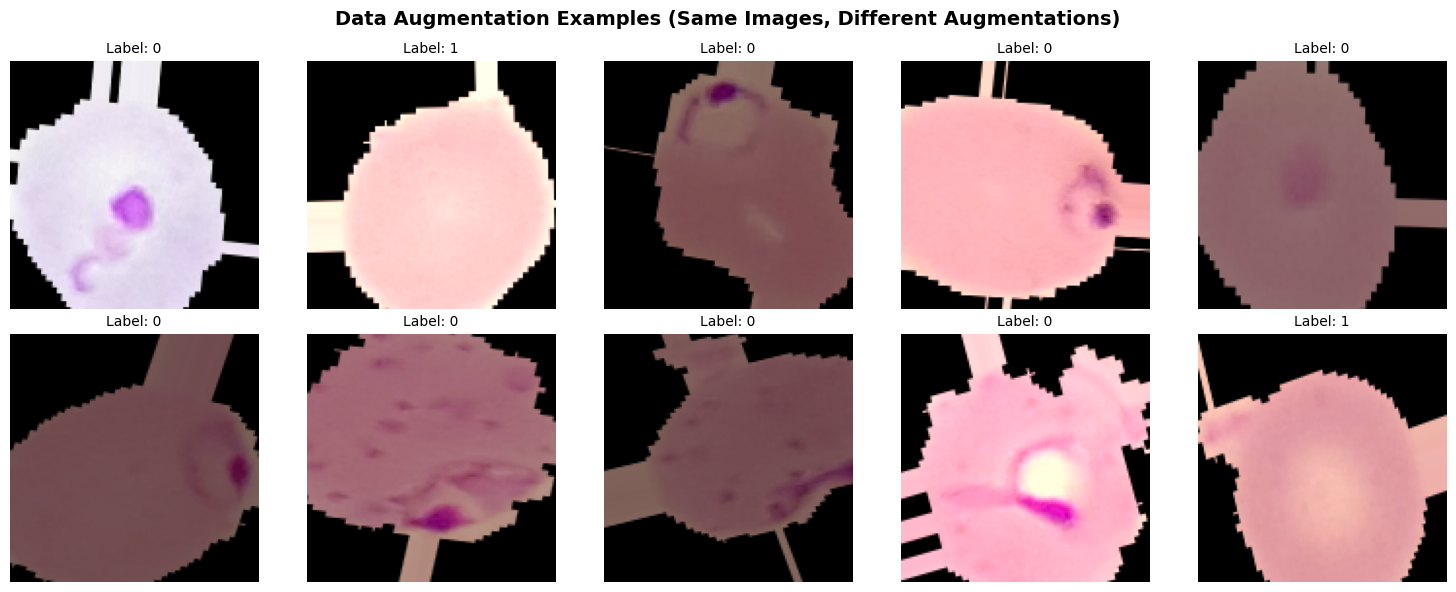

Data Augmentation Benefits:
 Creates infinite variations of training images
 Prevents overfitting by showing diverse examples
 Improves model generalization to new data
Found 22046 images belonging to 2 classes.


In [ ]:
# visualize augmented images
def visualize_augmentation(generator, num_images=5):
    """Visualize original vs augmented images"""

    # Get a batch
    batch_images, batch_labels = next(generator)

    # Plot
    fig, axes = plt.subplots(2, num_images, figsize=(15, 6))

    for i in range(num_images):
        # Original (first row)
        axes[0, i].imshow(batch_images[i])
        axes[0, i].axis('off')
        axes[0, i].set_title(f"Label: {int(batch_labels[i])}", fontsize=10)

        # Augmented (second row - get another batch)
        if i == 0:
            axes[0, i].set_ylabel('Batch 1', fontsize=12, fontweight='bold')

    # Get another batch to show augmentation variation
    batch_images2, batch_labels2 = next(generator)

    for i in range(num_images):
        axes[1, i].imshow(batch_images2[i])
        axes[1, i].axis('off')
        axes[1, i].set_title(f"Label: {int(batch_labels2[i])}", fontsize=10)

        if i == 0:
            axes[1, i].set_ylabel('Batch 2', fontsize=12, fontweight='bold')

    plt.suptitle('Data Augmentation Examples (Same Images, Different Augmentations)',
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

    print("Data Augmentation Benefits:")
    print(" Creates infinite variations of training images")
    print(" Prevents overfitting by showing diverse examples")
    print(" Improves model generalization to new data")

# Visualize
visualize_augmentation(train_generator, num_images=5)

# Reset generator
train_generator = train_datagen.flow_from_directory(
    training_path,
    target_size=(Image_size, Image_size),
    batch_size=Batch_size,
    class_mode=class_mode,
    shuffle=True,
    seed=42
)

In [ ]:
# Experiment 1: Baseline Configuration
exp1_config = {
    'name': 'exp1_baseline',
    'description': 'Baseline: Frozen VGG16 with simple top layers',
    'freeze_layers': 'all',
    'dense_units': [512],
    'dropout_rate': 0.5,
    'learning_rate': 0.001,
    'use_batch_norm': False,
    'regularization': 0.0,
    'use_augmentation': False,
    'epochs': 20,
    'batch_size': 32
}

# Build baseline model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze all layers

# Build custom classification head
inputs = keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model_exp1 = keras.Model(inputs, outputs, name='VGG16_Baseline')

# Compile model
model_exp1.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy',
             keras.metrics.Precision(name='precision'),
             keras.metrics.Recall(name='recall'),
             keras.metrics.AUC(name='auc')]
)

# Display model architecture
model_exp1.summary()

# Count trainable vs non-trainable parameters
trainable_count = sum([tf.size(w).numpy() for w in model_exp1.trainable_weights])
non_trainable_count = sum([tf.size(w).numpy() for w in model_exp1.non_trainable_weights])

print(f"\nParameter Analysis:")
print(f"  Trainable parameters: {trainable_count:,}")
print(f"  Non-trainable parameters: {non_trainable_count:,}")
print(f"  Total parameters: {trainable_count + non_trainable_count:,}")
print(f"  Percentage trainable: {100 * trainable_count / (trainable_count + non_trainable_count):.2f}%")

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "VGG16_Baseline"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,977,857 (57.14 MB)

 Trainable params: 263,169 (1.00 MB)

 Non-trainable params: 14,714,688 (56.13 MB)


Parameter Analysis:
  Trainable parameters: 263,169
  Non-trainable parameters: 14,714,688
  Total parameters: 14,977,857
  Percentage trainable: 1.76%


In [ ]:
# Define data directories - UPDATE THESE PATHS
TRAIN_DIR = './train'
VAL_DIR = './validation'
TEST_DIR = './test'

# Model hyperparameters
IMG_SIZE = (224, 224)  # VGG16 expects 224x224 images
BATCH_SIZE = 32
EPOCHS = 25

# Create output directory for results
OUTPUT_DIR = './vgg16_experiments'
os.makedirs(OUTPUT_DIR, exist_ok=True)

print(f"Configuration:")
print(f"  Image Size: {IMG_SIZE}")
print(f"  Batch Size: {BATCH_SIZE}")
print(f"  Output Directory: {OUTPUT_DIR}")

Configuration:
  Image Size: (224, 224)
  Batch Size: 32
  Output Directory: ./vgg16_experiments


In [ ]:
# Create data generators without augmentation
train_datagen_exp1 = ImageDataGenerator(rescale=1./255)
val_test_datagen = ImageDataGenerator(rescale=1./255)

train_gen_exp1 = train_datagen_exp1.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True,
    seed=42
)

val_gen_exp1 = val_test_datagen.flow_from_directory(
    VAL_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False,
    seed=42
)

test_gen_exp1 = val_test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False,
    seed=42
)

print("Data generators created successfully")
print(f"Class indices: {train_gen_exp1.class_indices}")

Found 22046 images belonging to 2 classes.
Found 2756 images belonging to 2 classes.
Found 2756 images belonging to 2 classes.
Data generators created successfully
Class indices: {'Parasitized': 0, 'Uninfected': 1}


In [ ]:
# Define callbacks
callbacks_exp1 = [
    callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    ),
    callbacks.ModelCheckpoint(
        filepath=os.path.join(OUTPUT_DIR, 'exp1_best_model.h5'),
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

# Train model
print("Starting training for Experiment 1...")
history_exp1 = model_exp1.fit(
    train_gen_exp1,
    validation_data=val_gen_exp1,
    epochs=exp1_config['epochs'],
    callbacks=callbacks_exp1,
    verbose=1
)

print("\nTraining completed!")

Starting training for Experiment 1...
Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - accuracy: 0.7527 - auc: 0.8338 - loss: 0.4892 - precision: 0.7430 - recall: 0.7710
Epoch 1: val_accuracy improved from -inf to 0.90385, saving model to ./vgg16_experiments/exp1_best_model.h5


689/689 ━━━━━━━━━━━━━━━━━━━━ 161s 211ms/step - accuracy: 0.7528 - auc: 0.8339 - loss: 0.4890 - precision: 0.7431 - recall: 0.7711 - val_accuracy: 0.9038 - val_auc: 0.9635 - val_loss: 0.2588 - val_precision: 0.8753 - val_recall: 0.9419 - learning_rate: 0.0010
Epoch 2/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.8903 - auc: 0.9515 - loss: 0.2801 - precision: 0.8687 - recall: 0.9182
Epoch 2: val_accuracy did not improve from 0.90385
689/689 ━━━━━━━━━━━━━━━━━━━━ 127s 184ms/step - accuracy: 0.8903 - auc: 0.9515 - loss: 0.2801 - precision: 0.8687 - recall: 0.9182 - val_accuracy: 0.9002 - val_auc: 0.9705 - val_loss: 0.2449 - val_precision: 0.8528 - val_recall: 0.9673 - learning_rate: 0.0010
Epoch 3/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.8974 - auc: 0.9583 - loss: 0.2579 - precision: 0.8781 - recall: 0.9245
Epoch 3: val_accuracy improved from 0.90385 to 0.90711, saving model to ./vgg16_experiments/exp1_best_model.h5


689/689 ━━━━━━━━━━━━━━━━━━━━ 127s 184ms/step - accuracy: 0.8974 - auc: 0.9583 - loss: 0.2578 - precision: 0.8781 - recall: 0.9245 - val_accuracy: 0.9071 - val_auc: 0.9725 - val_loss: 0.2261 - val_precision: 0.8648 - val_recall: 0.9652 - learning_rate: 0.0010
Epoch 4/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.9107 - auc: 0.9656 - loss: 0.2331 - precision: 0.8926 - recall: 0.9335
Epoch 4: val_accuracy improved from 0.90711 to 0.91836, saving model to ./vgg16_experiments/exp1_best_model.h5


689/689 ━━━━━━━━━━━━━━━━━━━━ 127s 184ms/step - accuracy: 0.9107 - auc: 0.9656 - loss: 0.2331 - precision: 0.8926 - recall: 0.9335 - val_accuracy: 0.9184 - val_auc: 0.9747 - val_loss: 0.2081 - val_precision: 0.8867 - val_recall: 0.9594 - learning_rate: 0.0010
Epoch 5/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.9127 - auc: 0.9680 - loss: 0.2242 - precision: 0.8969 - recall: 0.9357
Epoch 5: val_accuracy improved from 0.91836 to 0.92562, saving model to ./vgg16_experiments/exp1_best_model.h5


689/689 ━━━━━━━━━━━━━━━━━━━━ 127s 184ms/step - accuracy: 0.9127 - auc: 0.9680 - loss: 0.2242 - precision: 0.8969 - recall: 0.9357 - val_accuracy: 0.9256 - val_auc: 0.9756 - val_loss: 0.2036 - val_precision: 0.9247 - val_recall: 0.9267 - learning_rate: 0.0010
Epoch 6/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.9162 - auc: 0.9692 - loss: 0.2188 - precision: 0.8978 - recall: 0.9384
Epoch 6: val_accuracy did not improve from 0.92562
689/689 ━━━━━━━━━━━━━━━━━━━━ 127s 184ms/step - accuracy: 0.9162 - auc: 0.9692 - loss: 0.2188 - precision: 0.8978 - recall: 0.9384 - val_accuracy: 0.9097 - val_auc: 0.9758 - val_loss: 0.2254 - val_precision: 0.8630 - val_recall: 0.9739 - learning_rate: 0.0010
Epoch 7/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.9166 - auc: 0.9723 - loss: 0.2106 - precision: 0.9006 - recall: 0.9345
Epoch 7: val_accuracy improved from 0.92562 to 0.92707, saving model to ./vgg16_experiments/exp1_best_model.h5


689/689 ━━━━━━━━━━━━━━━━━━━━ 127s 185ms/step - accuracy: 0.9166 - auc: 0.9723 - loss: 0.2106 - precision: 0.9006 - recall: 0.9345 - val_accuracy: 0.9271 - val_auc: 0.9771 - val_loss: 0.1939 - val_precision: 0.9118 - val_recall: 0.9456 - learning_rate: 0.0010
Epoch 8/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.9201 - auc: 0.9727 - loss: 0.2088 - precision: 0.9049 - recall: 0.9384
Epoch 8: val_accuracy did not improve from 0.92707
689/689 ━━━━━━━━━━━━━━━━━━━━ 126s 183ms/step - accuracy: 0.9201 - auc: 0.9727 - loss: 0.2088 - precision: 0.9049 - recall: 0.9384 - val_accuracy: 0.9238 - val_auc: 0.9774 - val_loss: 0.1930 - val_precision: 0.8973 - val_recall: 0.9572 - learning_rate: 0.0010
Epoch 9/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.9202 - auc: 0.9724 - loss: 0.2066 - precision: 0.9045 - recall: 0.9397
Epoch 9: val_accuracy did not improve from 0.92707
689/689 ━━━━━━━━━━━━━━━━━━━━ 127s 184ms/step - accuracy: 0.9202 - auc: 0.9724 - loss: 0.2066 - precisi

689/689 ━━━━━━━━━━━━━━━━━━━━ 127s 184ms/step - accuracy: 0.9178 - auc: 0.9720 - loss: 0.2091 - precision: 0.9017 - recall: 0.9375 - val_accuracy: 0.9332 - val_auc: 0.9789 - val_loss: 0.1834 - val_precision: 0.9270 - val_recall: 0.9405 - learning_rate: 0.0010
Epoch 13/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.9217 - auc: 0.9734 - loss: 0.2040 - precision: 0.9073 - recall: 0.9400
Epoch 13: val_accuracy improved from 0.93324 to 0.93433, saving model to ./vgg16_experiments/exp1_best_model.h5


689/689 ━━━━━━━━━━━━━━━━━━━━ 127s 184ms/step - accuracy: 0.9217 - auc: 0.9734 - loss: 0.2040 - precision: 0.9073 - recall: 0.9400 - val_accuracy: 0.9343 - val_auc: 0.9790 - val_loss: 0.1814 - val_precision: 0.9218 - val_recall: 0.9492 - learning_rate: 0.0010
Epoch 14/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.9250 - auc: 0.9740 - loss: 0.2015 - precision: 0.9132 - recall: 0.9405
Epoch 14: val_accuracy improved from 0.93433 to 0.93505, saving model to ./vgg16_experiments/exp1_best_model.h5


689/689 ━━━━━━━━━━━━━━━━━━━━ 127s 184ms/step - accuracy: 0.9250 - auc: 0.9740 - loss: 0.2015 - precision: 0.9132 - recall: 0.9404 - val_accuracy: 0.9351 - val_auc: 0.9799 - val_loss: 0.1831 - val_precision: 0.9322 - val_recall: 0.9383 - learning_rate: 0.0010
Epoch 15/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.9251 - auc: 0.9751 - loss: 0.1972 - precision: 0.9115 - recall: 0.9408
Epoch 15: val_accuracy did not improve from 0.93505
689/689 ━━━━━━━━━━━━━━━━━━━━ 126s 184ms/step - accuracy: 0.9251 - auc: 0.9751 - loss: 0.1972 - precision: 0.9115 - recall: 0.9408 - val_accuracy: 0.9351 - val_auc: 0.9798 - val_loss: 0.1817 - val_precision: 0.9310 - val_recall: 0.9398 - learning_rate: 0.0010
Epoch 16/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.9282 - auc: 0.9752 - loss: 0.1964 - precision: 0.9125 - recall: 0.9463
Epoch 16: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 16: val_accuracy did not improve from 0.93505
689/689 ━━━━━━━━━━━━

689/689 ━━━━━━━━━━━━━━━━━━━━ 127s 184ms/step - accuracy: 0.9323 - auc: 0.9786 - loss: 0.1823 - precision: 0.9193 - recall: 0.9469 - val_accuracy: 0.9354 - val_auc: 0.9799 - val_loss: 0.1762 - val_precision: 0.9208 - val_recall: 0.9528 - learning_rate: 5.0000e-04
Epoch 18/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.9309 - auc: 0.9771 - loss: 0.1862 - precision: 0.9188 - recall: 0.9479
Epoch 18: val_accuracy did not improve from 0.93541
689/689 ━━━━━━━━━━━━━━━━━━━━ 127s 184ms/step - accuracy: 0.9309 - auc: 0.9771 - loss: 0.1862 - precision: 0.9188 - recall: 0.9479 - val_accuracy: 0.9347 - val_auc: 0.9801 - val_loss: 0.1815 - val_precision: 0.9398 - val_recall: 0.9289 - learning_rate: 5.0000e-04
Epoch 19/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.9319 - auc: 0.9790 - loss: 0.1808 - precision: 0.9198 - recall: 0.9448
Epoch 19: val_accuracy did not improve from 0.93541
689/689 ━━━━━━━━━━━━━━━━━━━━ 126s 183ms/step - accuracy: 0.9319 - auc: 0.9790 - loss: 0.18

In [ ]:
# Evaluate on test set
test_gen_exp1.reset()
test_loss, test_acc, test_prec, test_rec, test_auc = model_exp1.evaluate(test_gen_exp1, verbose=1)
test_f1 = 2 * (test_prec * test_rec) / (test_prec + test_rec + 1e-7)

# Get predictions
test_gen_exp1.reset()
y_pred_proba_exp1 = model_exp1.predict(test_gen_exp1, verbose=1)
y_pred_exp1 = (y_pred_proba_exp1 > 0.5).astype(int).flatten()
y_true_exp1 = test_gen_exp1.classes

# Print results
print("\n" + "="*80)
print("EXPERIMENT 1: BASELINE RESULTS")
print("="*80)
print(f"Test Accuracy:  {test_acc:.4f}")
print(f"Test Precision: {test_prec:.4f}")
print(f"Test Recall:    {test_rec:.4f}")
print(f"Test F1-Score:  {test_f1:.4f}")
print(f"Test AUC:       {test_auc:.4f}")
print(f"Test Loss:      {test_loss:.4f}")
print("="*80)

# Detailed classification report
print("\nDetailed Classification Report:")
print(classification_report(y_true_exp1, y_pred_exp1,
                          target_names=['Uninfected', 'Parasitized']))

87/87 ━━━━━━━━━━━━━━━━━━━━ 14s 161ms/step - accuracy: 0.9130 - auc: 0.5023 - loss: 0.1878 - precision: 0.4012 - recall: 0.4846
87/87 ━━━━━━━━━━━━━━━━━━━━ 15s 165ms/step

EXPERIMENT 1: BASELINE RESULTS
Test Accuracy:  0.9318
Test Precision: 0.9149
Test Recall:    0.9521
Test F1-Score:  0.9331
Test AUC:       0.9819
Test Loss:      0.1681

Detailed Classification Report:
              precision    recall  f1-score   support

  Uninfected       0.95      0.91      0.93      1378
 Parasitized       0.91      0.95      0.93      1378

    accuracy                           0.93      2756
   macro avg       0.93      0.93      0.93      2756
weighted avg       0.93      0.93      0.93      2756



In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc as sk_auc
import os
def plot_experiment_results(name, history, y_true, y_pred, y_prob):
    # 1. Learning Curves
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    axes[0].plot(history.history['loss'], label='Train Loss', color='#2E86AB')
    axes[0].plot(history.history['val_loss'], label='Val Loss', color='#A23B72')
    axes[0].set_title(f'{name}: Loss')
    axes[0].legend()

    axes[1].plot(history.history['accuracy'], label='Train Acc', color='#2E86AB')
    axes[1].plot(history.history['val_accuracy'], label='Val Acc', color='#A23B72')
    axes[1].set_title(f'{name}: Accuracy')
    axes[1].legend()
    plt.show()

    # 2. Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(7, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Uninfected', 'Parasitized'], yticklabels=['Uninfected', 'Parasitized'])
    tn, fp, fn, tp = cm.ravel()
    metrics_text = f'Sensitivity: {tp/(tp+fn):.3f}\nSpecificity: {tn/(tn+fp):.3f}'
    plt.text(2.3, 0.5, metrics_text, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    plt.title(f'{name}: Confusion Matrix')
    plt.show()

    # 3. ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = sk_auc(fpr, tpr)
    plt.figure(figsize=(7, 5))
    plt.plot(fpr, tpr, color='darkorange', label=f'AUC = {roc_auc:.3f}')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.title(f'{name}: ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

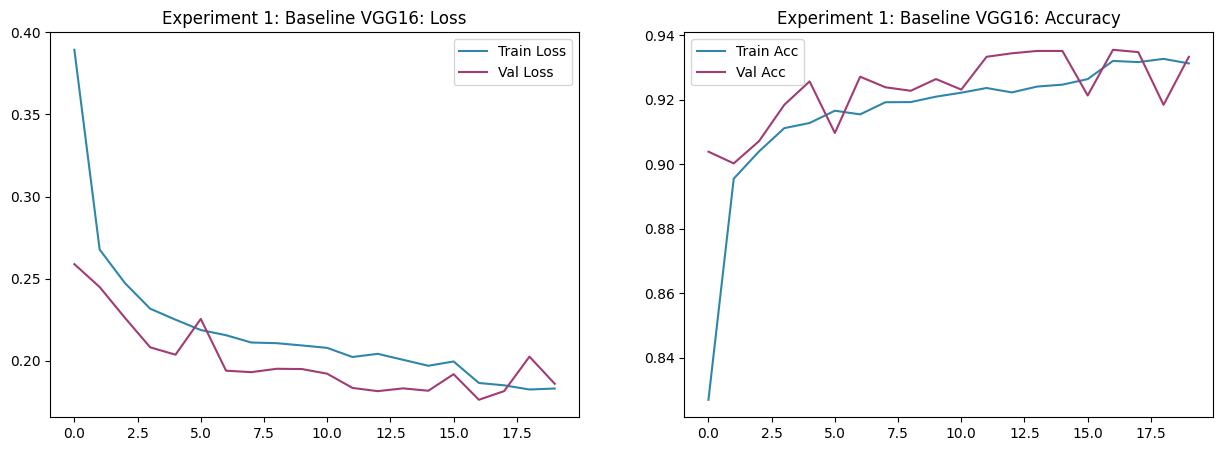

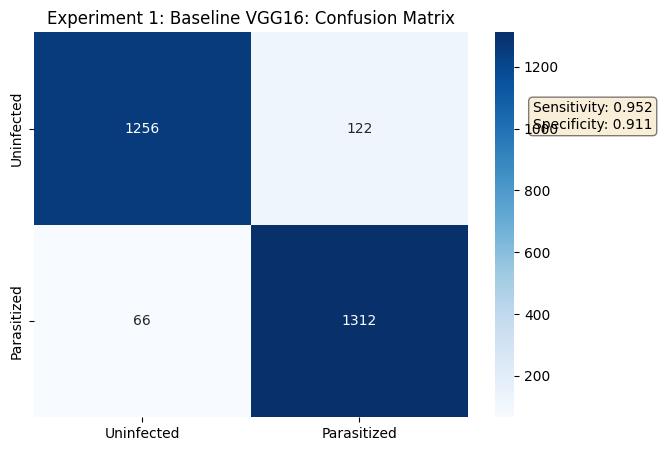

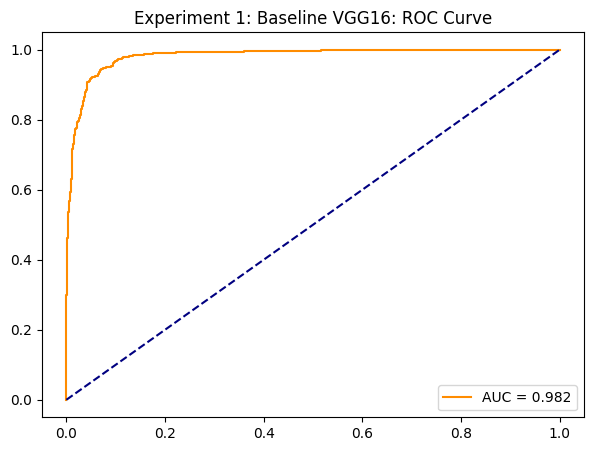

In [ ]:
plot_experiment_results("Experiment 1: Baseline VGG16", history_exp1, y_true_exp1, y_pred_exp1, y_pred_proba_exp1)

In [ ]:
# Experiment 2
base_model_exp2 = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model_exp2.trainable = False

inputs_exp2 = keras.Input(shape=(224, 224, 3))
x_exp2 = base_model_exp2(inputs_exp2, training=False)
x_exp2 = layers.GlobalAveragePooling2D()(x_exp2)
x_exp2 = layers.Dense(512, activation='relu')(x_exp2)
x_exp2 = layers.Dropout(0.5)(x_exp2)
outputs_exp2 = layers.Dense(1, activation='sigmoid')(x_exp2)

model_exp2 = keras.Model(inputs_exp2, outputs_exp2, name='VGG16_Augmented')

model_exp2.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy',
             keras.metrics.Precision(name='precision'),
             keras.metrics.Recall(name='recall'),
             keras.metrics.AUC(name='auc')]
)

# Create augmented data generator
train_datagen_exp2 = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.15,
    fill_mode='nearest'
)

train_gen_exp2 = train_datagen_exp2.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True,
    seed=42
)

print("Experiment 2: Model and augmented data generator created")

Found 22046 images belonging to 2 classes.
Experiment 2: Model and augmented data generator created


In [ ]:
# Train Experiment 2
callbacks_exp2 = [
    callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7, verbose=1),
    callbacks.ModelCheckpoint(filepath=os.path.join(OUTPUT_DIR, 'exp2_best_model.h5'),
                            monitor='val_accuracy', save_best_only=True, verbose=1)
]

print("Starting training for Experiment 2 (with augmentation)...")
history_exp2 = model_exp2.fit(
    train_gen_exp2,
    validation_data=val_gen_exp1,  # Validation data is not augmented
    epochs=25,
    callbacks=callbacks_exp2,
    verbose=1
)

# Evaluate
test_gen_exp1.reset()
results_exp2 = model_exp2.evaluate(test_gen_exp1, verbose=1)
print(f"\nExperiment 2 Test Results:")
print(f"Accuracy: {results_exp2[1]:.4f}, Precision: {results_exp2[2]:.4f}, Recall: {results_exp2[3]:.4f}, AUC: {results_exp2[4]:.4f}")

Starting training for Experiment 2 (with augmentation)...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step - accuracy: 0.7311 - auc: 0.8010 - loss: 0.5270 - precision: 0.7210 - recall: 0.7600
Epoch 1: val_accuracy improved from -inf to 0.84579, saving model to ./vgg16_experiments/exp2_best_model.h5


689/689 ━━━━━━━━━━━━━━━━━━━━ 315s 451ms/step - accuracy: 0.7312 - auc: 0.8011 - loss: 0.5268 - precision: 0.7210 - recall: 0.7601 - val_accuracy: 0.8458 - val_auc: 0.9524 - val_loss: 0.3459 - val_precision: 0.7759 - val_recall: 0.9724 - learning_rate: 0.0010
Epoch 2/25
689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step - accuracy: 0.8615 - auc: 0.9300 - loss: 0.3342 - precision: 0.8366 - recall: 0.8983
Epoch 2: val_accuracy improved from 0.84579 to 0.90747, saving model to ./vgg16_experiments/exp2_best_model.h5


689/689 ━━━━━━━━━━━━━━━━━━━━ 304s 440ms/step - accuracy: 0.8615 - auc: 0.9300 - loss: 0.3342 - precision: 0.8366 - recall: 0.8983 - val_accuracy: 0.9075 - val_auc: 0.9631 - val_loss: 0.2599 - val_precision: 0.8902 - val_recall: 0.9296 - learning_rate: 0.0010
Epoch 3/25
689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step - accuracy: 0.8730 - auc: 0.9374 - loss: 0.3138 - precision: 0.8513 - recall: 0.9074
Epoch 3: val_accuracy improved from 0.90747 to 0.91001, saving model to ./vgg16_experiments/exp2_best_model.h5


689/689 ━━━━━━━━━━━━━━━━━━━━ 302s 439ms/step - accuracy: 0.8730 - auc: 0.9374 - loss: 0.3138 - precision: 0.8513 - recall: 0.9074 - val_accuracy: 0.9100 - val_auc: 0.9649 - val_loss: 0.2475 - val_precision: 0.8929 - val_recall: 0.9318 - learning_rate: 0.0010
Epoch 4/25
689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step - accuracy: 0.8812 - auc: 0.9419 - loss: 0.3003 - precision: 0.8557 - recall: 0.9149
Epoch 4: val_accuracy did not improve from 0.91001
689/689 ━━━━━━━━━━━━━━━━━━━━ 301s 436ms/step - accuracy: 0.8812 - auc: 0.9419 - loss: 0.3003 - precision: 0.8557 - recall: 0.9149 - val_accuracy: 0.9067 - val_auc: 0.9667 - val_loss: 0.2393 - val_precision: 0.8690 - val_recall: 0.9579 - learning_rate: 0.0010
Epoch 5/25
689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step - accuracy: 0.8882 - auc: 0.9457 - loss: 0.2869 - precision: 0.8637 - recall: 0.9212
Epoch 5: val_accuracy did not improve from 0.91001
689/689 ━━━━━━━━━━━━━━━━━━━━ 302s 438ms/step - accuracy: 0.8882 - auc: 0.9457 - loss: 0.2869 - precisi

689/689 ━━━━━━━━━━━━━━━━━━━━ 304s 442ms/step - accuracy: 0.8830 - auc: 0.9450 - loss: 0.2901 - precision: 0.8562 - recall: 0.9188 - val_accuracy: 0.9107 - val_auc: 0.9699 - val_loss: 0.2282 - val_precision: 0.8729 - val_recall: 0.9615 - learning_rate: 0.0010
Epoch 7/25
689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step - accuracy: 0.8855 - auc: 0.9477 - loss: 0.2813 - precision: 0.8607 - recall: 0.9208
Epoch 7: val_accuracy did not improve from 0.91074
689/689 ━━━━━━━━━━━━━━━━━━━━ 305s 443ms/step - accuracy: 0.8855 - auc: 0.9477 - loss: 0.2813 - precision: 0.8607 - recall: 0.9208 - val_accuracy: 0.9100 - val_auc: 0.9693 - val_loss: 0.2292 - val_precision: 0.8717 - val_recall: 0.9615 - learning_rate: 0.0010
Epoch 8/25
689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step - accuracy: 0.8939 - auc: 0.9546 - loss: 0.2653 - precision: 0.8705 - recall: 0.9225
Epoch 8: val_accuracy improved from 0.91074 to 0.91437, saving model to ./vgg16_experiments/exp2_best_model.h5


689/689 ━━━━━━━━━━━━━━━━━━━━ 311s 452ms/step - accuracy: 0.8939 - auc: 0.9546 - loss: 0.2653 - precision: 0.8705 - recall: 0.9225 - val_accuracy: 0.9144 - val_auc: 0.9693 - val_loss: 0.2243 - val_precision: 0.8890 - val_recall: 0.9470 - learning_rate: 0.0010
Epoch 9/25
689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step - accuracy: 0.8929 - auc: 0.9499 - loss: 0.2767 - precision: 0.8706 - recall: 0.9227
Epoch 9: val_accuracy did not improve from 0.91437
689/689 ━━━━━━━━━━━━━━━━━━━━ 313s 455ms/step - accuracy: 0.8929 - auc: 0.9499 - loss: 0.2767 - precision: 0.8706 - recall: 0.9227 - val_accuracy: 0.9129 - val_auc: 0.9715 - val_loss: 0.2193 - val_precision: 0.8753 - val_recall: 0.9630 - learning_rate: 0.0010
Epoch 10/25
689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step - accuracy: 0.8911 - auc: 0.9494 - loss: 0.2792 - precision: 0.8704 - recall: 0.9206
Epoch 10: val_accuracy did not improve from 0.91437
689/689 ━━━━━━━━━━━━━━━━━━━━ 313s 454ms/step - accuracy: 0.8911 - auc: 0.9494 - loss: 0.2792 - preci

689/689 ━━━━━━━━━━━━━━━━━━━━ 315s 456ms/step - accuracy: 0.8900 - auc: 0.9509 - loss: 0.2743 - precision: 0.8651 - recall: 0.9239 - val_accuracy: 0.9151 - val_auc: 0.9706 - val_loss: 0.2144 - val_precision: 0.8945 - val_recall: 0.9412 - learning_rate: 0.0010
Epoch 13/25
689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step - accuracy: 0.8919 - auc: 0.9522 - loss: 0.2695 - precision: 0.8711 - recall: 0.9194
Epoch 13: val_accuracy did not improve from 0.91509
689/689 ━━━━━━━━━━━━━━━━━━━━ 312s 453ms/step - accuracy: 0.8919 - auc: 0.9522 - loss: 0.2695 - precision: 0.8711 - recall: 0.9194 - val_accuracy: 0.9122 - val_auc: 0.9718 - val_loss: 0.2304 - val_precision: 0.9284 - val_recall: 0.8933 - learning_rate: 0.0010
Epoch 14/25
689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step - accuracy: 0.8989 - auc: 0.9561 - loss: 0.2596 - precision: 0.8786 - recall: 0.9273
Epoch 14: val_accuracy improved from 0.91509 to 0.91836, saving model to ./vgg16_experiments/exp2_best_model.h5


689/689 ━━━━━━━━━━━━━━━━━━━━ 310s 450ms/step - accuracy: 0.8989 - auc: 0.9561 - loss: 0.2596 - precision: 0.8786 - recall: 0.9273 - val_accuracy: 0.9184 - val_auc: 0.9719 - val_loss: 0.2106 - val_precision: 0.9034 - val_recall: 0.9369 - learning_rate: 0.0010
Epoch 15/25
689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step - accuracy: 0.8951 - auc: 0.9537 - loss: 0.2658 - precision: 0.8736 - recall: 0.9248
Epoch 15: val_accuracy did not improve from 0.91836
689/689 ━━━━━━━━━━━━━━━━━━━━ 308s 447ms/step - accuracy: 0.8951 - auc: 0.9537 - loss: 0.2658 - precision: 0.8736 - recall: 0.9248 - val_accuracy: 0.9126 - val_auc: 0.9711 - val_loss: 0.2254 - val_precision: 0.9252 - val_recall: 0.8977 - learning_rate: 0.0010
Epoch 16/25
689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step - accuracy: 0.8943 - auc: 0.9513 - loss: 0.2691 - precision: 0.8708 - recall: 0.9279
Epoch 16: val_accuracy did not improve from 0.91836
689/689 ━━━━━━━━━━━━━━━━━━━━ 310s 450ms/step - accuracy: 0.8943 - auc: 0.9513 - loss: 0.2691 - pre

689/689 ━━━━━━━━━━━━━━━━━━━━ 310s 450ms/step - accuracy: 0.8957 - auc: 0.9558 - loss: 0.2628 - precision: 0.8727 - recall: 0.9261 - val_accuracy: 0.9213 - val_auc: 0.9737 - val_loss: 0.2081 - val_precision: 0.9272 - val_recall: 0.9144 - learning_rate: 0.0010
Epoch 24/25
689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step - accuracy: 0.8981 - auc: 0.9543 - loss: 0.2620 - precision: 0.8765 - recall: 0.9299
Epoch 24: val_accuracy did not improve from 0.92126
689/689 ━━━━━━━━━━━━━━━━━━━━ 307s 446ms/step - accuracy: 0.8981 - auc: 0.9543 - loss: 0.2620 - precision: 0.8765 - recall: 0.9299 - val_accuracy: 0.9176 - val_auc: 0.9735 - val_loss: 0.2045 - val_precision: 0.8977 - val_recall: 0.9427 - learning_rate: 0.0010
Epoch 25/25
689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step - accuracy: 0.9033 - auc: 0.9555 - loss: 0.2587 - precision: 0.8788 - recall: 0.9368
Epoch 25: val_accuracy did not improve from 0.92126
689/689 ━━━━━━━━━━━━━━━━━━━━ 302s 439ms/step - accuracy: 0.9033 - auc: 0.9555 - loss: 0.2587 - pre

In [ ]:
print("\nGenerating predictions for Experiment 2...")
test_gen_exp1.reset()
y_pred_proba_exp2 = model_exp2.predict(test_gen_exp1, verbose=1).flatten()
y_pred_exp2 = (y_pred_proba_exp2 > 0.5).astype(int)
y_true_exp2 = test_gen_exp1.classes


Generating predictions for Experiment 2...
87/87 ━━━━━━━━━━━━━━━━━━━━ 16s 168ms/step


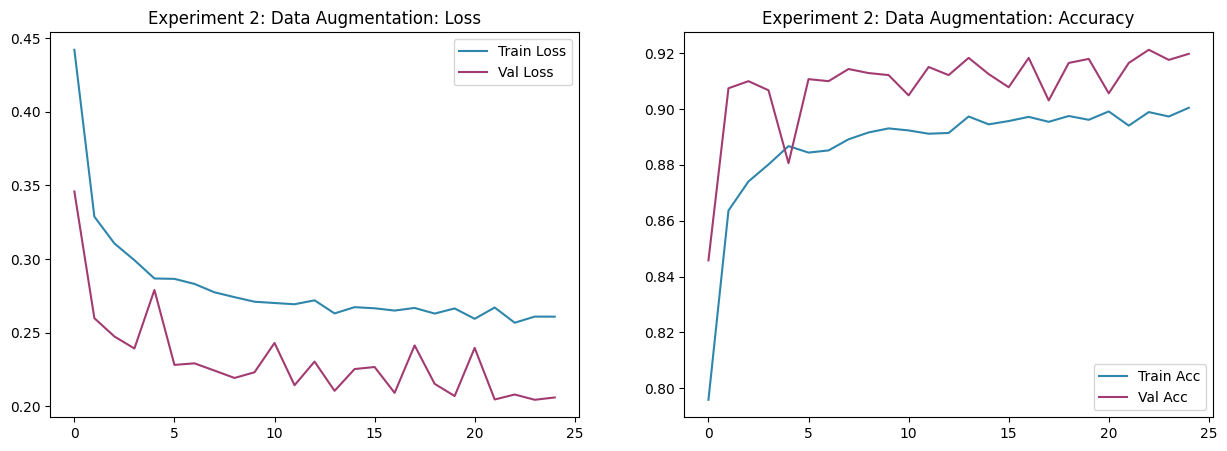

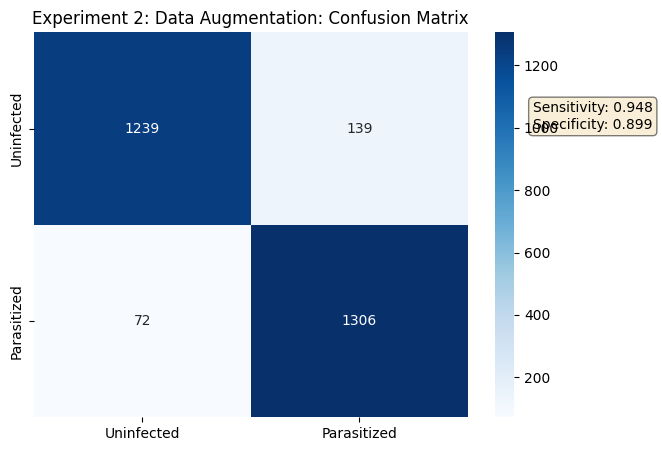

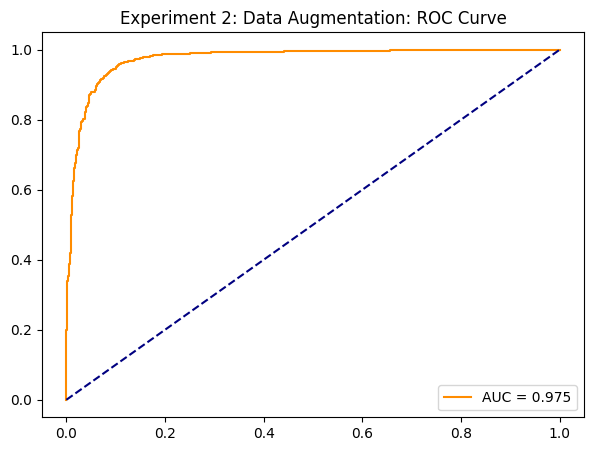

In [ ]:
plot_experiment_results("Experiment 2: Data Augmentation", history_exp2, y_true_exp2, y_pred_exp2, y_pred_proba_exp2)

In [ ]:
# Load base model
base_model_exp3 = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)
base_model_exp3.trainable = False  # KEEP FROZEN

# Build model
inputs_exp3 = keras.Input(shape=(224, 224, 3))
x_exp3 = base_model_exp3(inputs_exp3, training=False)
x_exp3 = layers.GlobalAveragePooling2D()(x_exp3)

# Deeper classifier head
x_exp3 = layers.Dense(1024, activation='relu')(x_exp3)
x_exp3 = layers.Dropout(0.5)(x_exp3)

x_exp3 = layers.Dense(512, activation='relu')(x_exp3)
x_exp3 = layers.Dropout(0.5)(x_exp3)

x_exp3 = layers.Dense(256, activation='relu')(x_exp3)
x_exp3 = layers.Dropout(0.5)(x_exp3)

outputs_exp3 = layers.Dense(1, activation='sigmoid')(x_exp3)

model_exp3 = keras.Model(
    inputs=inputs_exp3,
    outputs=outputs_exp3,
    name='VGG16_Deeper_Head'
)

model_exp3.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        keras.metrics.Precision(name='precision'),
        keras.metrics.Recall(name='recall'),
        keras.metrics.AUC(name='auc')
    ]
)

# Augmented data generator
train_datagen_exp3 = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.15,
    fill_mode='nearest'
)

train_gen_exp3 = train_datagen_exp3.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True,
    seed=42
)

print("Experiment 3: Deeper classifier model and augmented data generator created")


Found 22047 images belonging to 2 classes.
Experiment 3: Deeper classifier model and augmented data generator created


In [ ]:
# Train Experiment 3
callbacks_exp3 = [
    callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7, verbose=1),
    callbacks.ModelCheckpoint(filepath=os.path.join(OUTPUT_DIR, 'exp3_best_model.h5'),
                            monitor='val_accuracy', save_best_only=True, verbose=1)
]

print("Starting training for Experiment 3 (with augmentation)...")
history_exp3 = model_exp3.fit(
    train_gen_exp3,
    validation_data=val_gen_exp1,
    epochs=15,
    callbacks=callbacks_exp3,
    verbose=1
)


Starting training for Experiment 3 (with augmentation)...
Epoch 1/15
689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step - accuracy: 0.7038 - auc: 0.7765 - loss: 0.5489 - precision: 0.6942 - recall: 0.7169
Epoch 1: val_accuracy improved from -inf to 0.86139, saving model to ./vgg16_experiments/exp3_best_model.h5


689/689 ━━━━━━━━━━━━━━━━━━━━ 311s 452ms/step - accuracy: 0.7039 - auc: 0.7766 - loss: 0.5488 - precision: 0.6943 - recall: 0.7170 - val_accuracy: 0.8614 - val_auc: 0.9543 - val_loss: 0.3207 - val_precision: 0.7961 - val_recall: 0.9717 - learning_rate: 0.0010
Epoch 2/15
689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step - accuracy: 0.8291 - auc: 0.8996 - loss: 0.3932 - precision: 0.8047 - recall: 0.8715
Epoch 2: val_accuracy improved from 0.86139 to 0.89623, saving model to ./vgg16_experiments/exp3_best_model.h5


689/689 ━━━━━━━━━━━━━━━━━━━━ 308s 447ms/step - accuracy: 0.8291 - auc: 0.8996 - loss: 0.3932 - precision: 0.8047 - recall: 0.8715 - val_accuracy: 0.8962 - val_auc: 0.9632 - val_loss: 0.2678 - val_precision: 0.8514 - val_recall: 0.9601 - learning_rate: 0.0010
Epoch 3/15
689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step - accuracy: 0.8355 - auc: 0.9036 - loss: 0.3787 - precision: 0.7962 - recall: 0.9046
Epoch 3: val_accuracy improved from 0.89623 to 0.90385, saving model to ./vgg16_experiments/exp3_best_model.h5


689/689 ━━━━━━━━━━━━━━━━━━━━ 309s 448ms/step - accuracy: 0.8355 - auc: 0.9036 - loss: 0.3787 - precision: 0.7962 - recall: 0.9046 - val_accuracy: 0.9038 - val_auc: 0.9641 - val_loss: 0.2854 - val_precision: 0.8664 - val_recall: 0.9550 - learning_rate: 0.0010
Epoch 4/15
689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step - accuracy: 0.8376 - auc: 0.8982 - loss: 0.3797 - precision: 0.7965 - recall: 0.9124
Epoch 4: val_accuracy improved from 0.90385 to 0.90602, saving model to ./vgg16_experiments/exp3_best_model.h5


689/689 ━━━━━━━━━━━━━━━━━━━━ 310s 449ms/step - accuracy: 0.8376 - auc: 0.8982 - loss: 0.3797 - precision: 0.7965 - recall: 0.9124 - val_accuracy: 0.9060 - val_auc: 0.9658 - val_loss: 0.2513 - val_precision: 0.8723 - val_recall: 0.9514 - learning_rate: 0.0010
Epoch 5/15
689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step - accuracy: 0.8527 - auc: 0.9123 - loss: 0.3536 - precision: 0.8096 - recall: 0.9196
Epoch 5: val_accuracy did not improve from 0.90602
689/689 ━━━━━━━━━━━━━━━━━━━━ 306s 444ms/step - accuracy: 0.8527 - auc: 0.9123 - loss: 0.3536 - precision: 0.8097 - recall: 0.9196 - val_accuracy: 0.8973 - val_auc: 0.9658 - val_loss: 0.2588 - val_precision: 0.9308 - val_recall: 0.8585 - learning_rate: 0.0010
Epoch 6/15
689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step - accuracy: 0.8562 - auc: 0.9155 - loss: 0.3488 - precision: 0.8280 - recall: 0.9002
Epoch 6: val_accuracy improved from 0.90602 to 0.91110, saving model to ./vgg16_experiments/exp3_best_model.h5


689/689 ━━━━━━━━━━━━━━━━━━━━ 305s 442ms/step - accuracy: 0.8562 - auc: 0.9155 - loss: 0.3488 - precision: 0.8280 - recall: 0.9002 - val_accuracy: 0.9111 - val_auc: 0.9703 - val_loss: 0.2405 - val_precision: 0.8794 - val_recall: 0.9528 - learning_rate: 0.0010
Epoch 7/15
689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step - accuracy: 0.8787 - auc: 0.9279 - loss: 0.3160 - precision: 0.8507 - recall: 0.9166
Epoch 7: val_accuracy did not improve from 0.91110
689/689 ━━━━━━━━━━━━━━━━━━━━ 303s 440ms/step - accuracy: 0.8787 - auc: 0.9279 - loss: 0.3160 - precision: 0.8507 - recall: 0.9166 - val_accuracy: 0.9053 - val_auc: 0.9621 - val_loss: 0.2693 - val_precision: 0.8610 - val_recall: 0.9666 - learning_rate: 0.0010
Epoch 8/15
689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step - accuracy: 0.8787 - auc: 0.9252 - loss: 0.3191 - precision: 0.8508 - recall: 0.9190
Epoch 8: val_accuracy did not improve from 0.91110
689/689 ━━━━━━━━━━━━━━━━━━━━ 302s 439ms/step - accuracy: 0.8787 - auc: 0.9252 - loss: 0.3191 - precisi


Generating predictions for Experiment 3...
87/87 ━━━━━━━━━━━━━━━━━━━━ 15s 166ms/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 14s 165ms/step - accuracy: 0.8899 - auc: 0.4952 - loss: 0.2756 - precision: 0.3756 - recall: 0.4830

Experiment 3 Test Results:
Accuracy: 0.9169, Precision: 0.8863, Recall: 0.9565, AUC: 0.9716


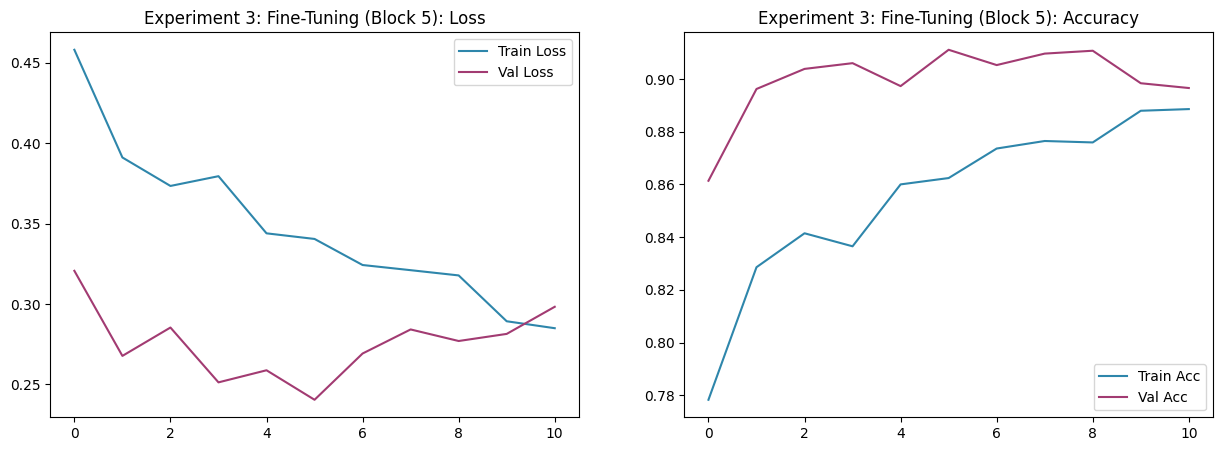

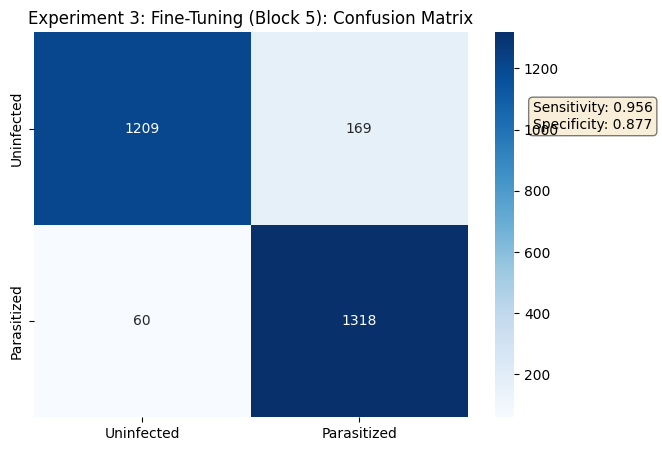

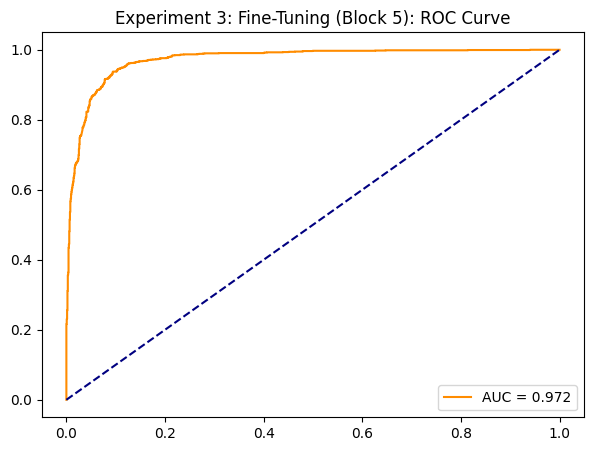

In [ ]:
print(f"\nGenerating predictions for Experiment 3...")
test_gen_exp1.reset()
y_pred_proba_exp3 = model_exp3.predict(test_gen_exp1, verbose=1).flatten()
y_pred_exp3 = (y_pred_proba_exp3 > 0.5).astype(int)
y_true_exp3 = test_gen_exp1.classes
# Evaluate
test_gen_exp1.reset()
results_exp3 = model_exp3.evaluate(test_gen_exp1, verbose=1)

print(f"\nExperiment 3 Test Results:") # Fixed label to Experiment 3
print(f"Accuracy: {results_exp3[1]:.4f}, Precision: {results_exp3[2]:.4f}, Recall: {results_exp3[3]:.4f}, AUC: {results_exp3[4]:.4f}")

# Call your visualization function
plot_experiment_results("Experiment 3: Fine-Tuning (Block 5)", history_exp3, y_true_exp3, y_pred_exp3, y_pred_proba_exp3)

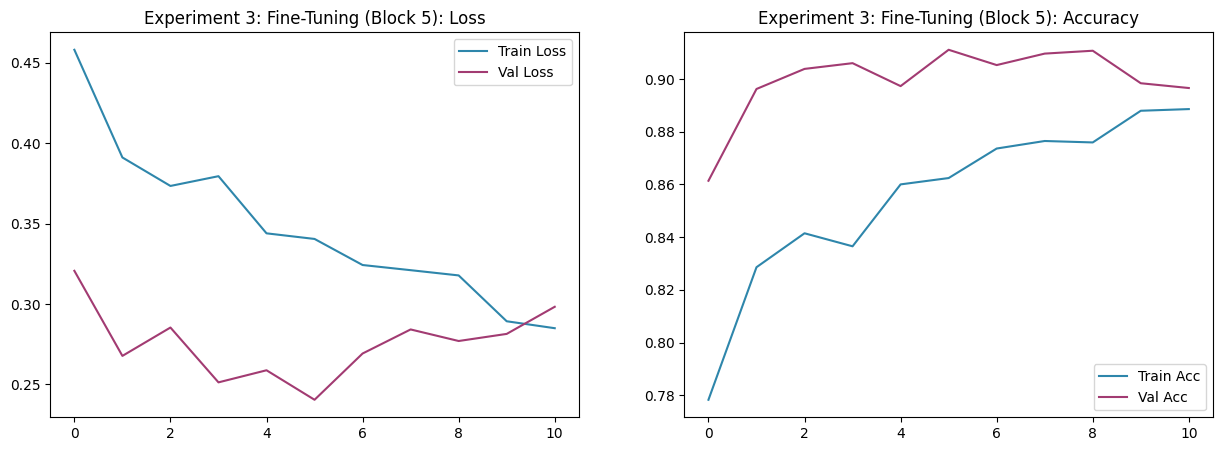

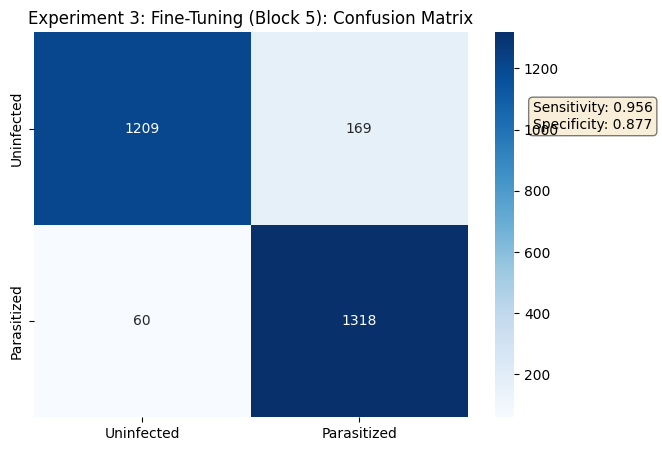

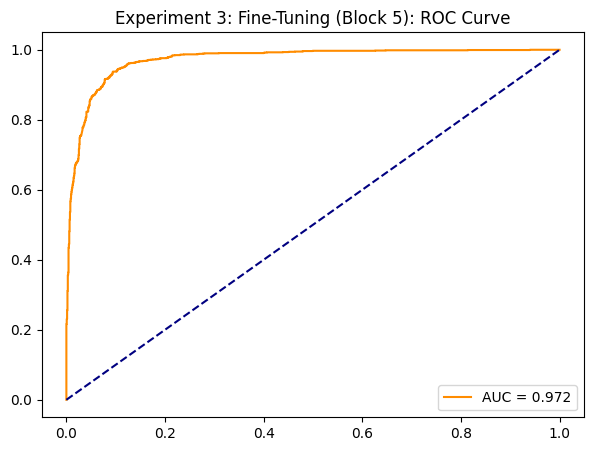

In [ ]:
plot_experiment_results("Experiment 3: Fine-Tuning (Block 5)", history_exp3, y_true_exp3, y_pred_exp3, y_pred_proba_exp3)

In [ ]:
# Load base model
base_model_exp3 = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)
base_model_exp3.trainable = False  # KEEP FROZEN

# Build model
inputs_exp3 = keras.Input(shape=(224, 224, 3))
x_exp3 = base_model_exp3(inputs_exp3, training=False)
x_exp3 = layers.GlobalAveragePooling2D()(x_exp3)

# Deeper classifier head
x_exp3 = layers.Dense(1024, activation='relu')(x_exp3)
x_exp3 = layers.Dropout(0.5)(x_exp3)

x_exp3 = layers.Dense(512, activation='relu')(x_exp3)
x_exp3 = layers.Dropout(0.5)(x_exp3)

x_exp3 = layers.Dense(256, activation='relu')(x_exp3)
x_exp3 = layers.Dropout(0.5)(x_exp3)

outputs_exp3 = layers.Dense(1, activation='sigmoid')(x_exp3)

model_exp3 = keras.Model(
    inputs=inputs_exp3,
    outputs=outputs_exp3,
    name='VGG16_Deeper_Head'
)

model_exp3.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        keras.metrics.Precision(name='precision'),
        keras.metrics.Recall(name='recall'),
        keras.metrics.AUC(name='auc')
    ]
)

# Augmented data generator
train_datagen_exp3 = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.15,
    fill_mode='nearest'
)

train_gen_exp3 = train_datagen_exp3.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True,
    seed=42
)

print("Experiment 3: Deeper classifier model and augmented data generator created")


Found 22046 images belonging to 2 classes.
Experiment 3: Deeper classifier model and augmented data generator created


In [ ]:

base_model = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

base_model.trainable = False

# Build Experiment 4 model
model_exp4 = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),

    layers.Dense(256),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.5),

    layers.Dense(1, activation='sigmoid')
])
model_exp4.compile(
    optimizer=optimizers.Adam(learning_rate=1e-3),
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc')
    ]
)
callbacks_exp4 = [
    callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    ),
    callbacks.ModelCheckpoint(
        filepath=os.path.join(OUTPUT_DIR, 'exp4_best_model.keras'),
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]
print("Starting training for Experiment")

history_exp4 = model_exp4.fit(
    train_gen_exp3,
    validation_data=val_gen_exp1,
    epochs=20,               # changed from 25 → 20
    callbacks=callbacks_exp4,
    verbose=1
)
print(f"\nGenerating predictions for Experiment4...")
test_gen_exp1.reset()
y_pred_proba_exp4 = model_exp4.predict(test_gen_exp1, verbose=1).flatten()
y_pred_exp4 = (y_pred_proba_exp4 > 0.5).astype(int)
y_true_exp4 = test_gen_exp1.classes
test_gen_exp1.reset()

results_exp4 = model_exp4.evaluate(test_gen_exp1, verbose=1)

print("\nExperiment 4 Test Results:")
print(f"Accuracy:  {results_exp4[1]:.4f}")
print(f"Precision: {results_exp4[2]:.4f}")
print(f"Recall:    {results_exp4[3]:.4f}")
print(f"AUC:       {results_exp4[4]:.4f}")


Starting training for Experiment


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step - accuracy: 0.8370 - auc: 0.9070 - loss: 0.3746 - precision: 0.8176 - recall: 0.8672
Epoch 1: val_accuracy improved from -inf to 0.68614, saving model to ./vgg16_experiments/exp4_best_model.keras
689/689 ━━━━━━━━━━━━━━━━━━━━ 348s 479ms/step - accuracy: 0.8371 - auc: 0.9070 - loss: 0.3745 - precision: 0.8177 - recall: 0.8672 - val_accuracy: 0.6861 - val_auc: 0.9546 - val_loss: 0.9244 - val_precision: 0.6146 - val_recall: 0.9985 - learning_rate: 0.0010
Epoch 2/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step - accuracy: 0.8845 - auc: 0.9476 - loss: 0.2866 - precision: 0.8656 - recall: 0.9080
Epoch 2: val_accuracy improved from 0.68614 to 0.91001, saving model to ./vgg16_experiments/exp4_best_model.keras
689/689 ━━━━━━━━━━━━━━━━━━━━ 308s 447ms/step - accuracy: 0.8845 - auc: 0.9476 - loss: 0.2866 - precision: 0.8656 - recall: 0.9080 - val_accuracy: 0.9100 - val_auc: 0.9706 - val_loss: 0.2381 - val_precision: 0.9387 - val_recall: 0.8774 - l

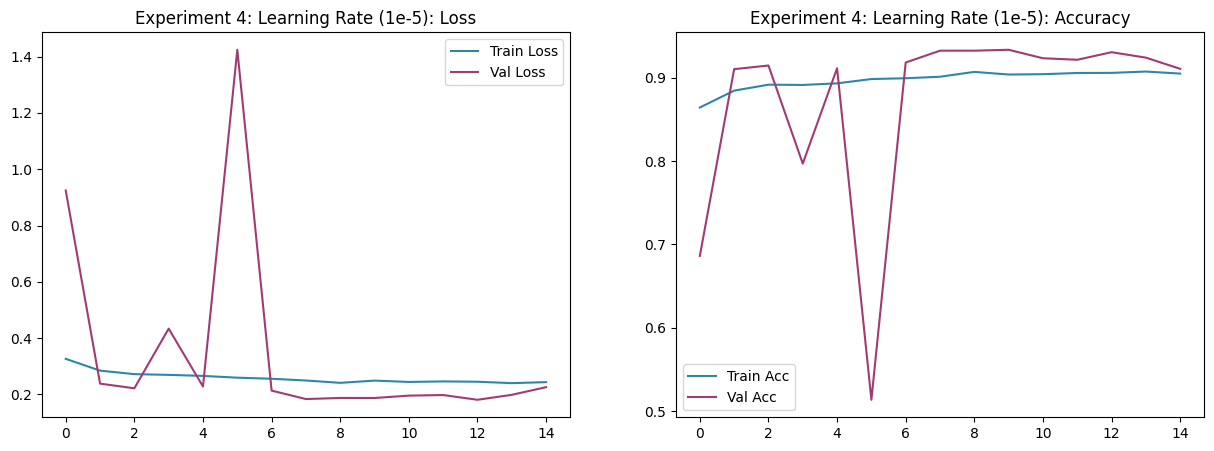

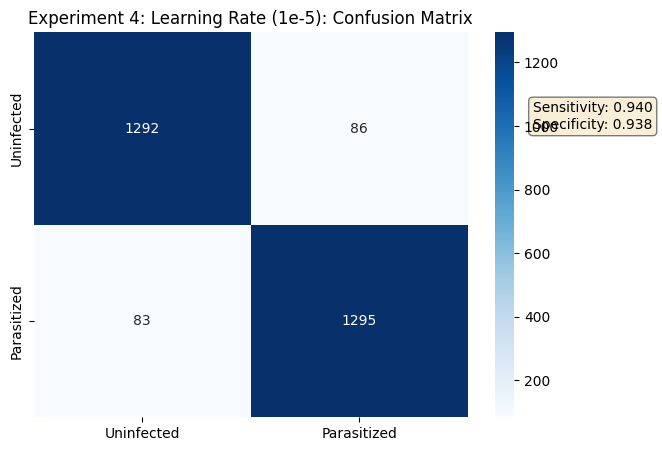

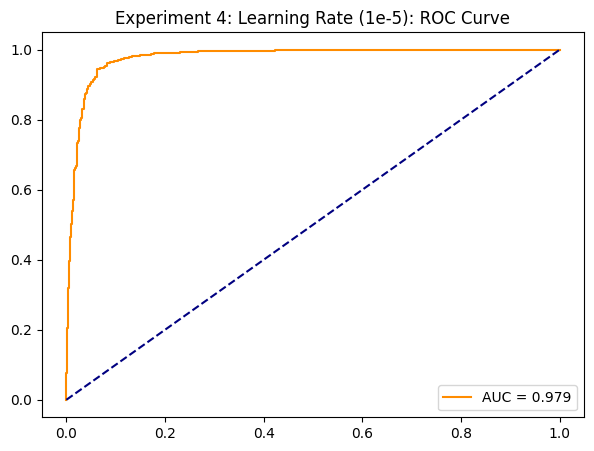

In [ ]:
plot_experiment_results("Experiment 4: Learning Rate (1e-5)", history_exp4, y_true_exp4, y_pred_exp4, y_pred_proba_exp4)